## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)


`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head(10)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
7,719014,2017-01-17 01:48:29.539573,control,old_page,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:

rows=df.shape[0]
rows

294478

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

In [5]:
df.user_id.duplicated().sum()

3894

d. The proportion of users converted.

In [6]:
converted_users=df.query("converted == 1 ")['user_id'].count()
df_convertion=(100/rows)*converted_users
df_convertion


11.965919355605513

e. The number of times the `new_page` and `treatment` don't line up.

In [7]:

new_page_treated = df.query("landing_page == 'new_page' & group =='treatment'")['user_id'].count()
old_page_control=df.query("landing_page == 'old_page' & group =='control'")['user_id'].count()

new_treatment_not_lined= rows-old_page_control-new_page_treated

new_treatment_not_lined

3893

f. Do any of the rows have missing values?

In [8]:
df.isnull().any().sum()

0

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [9]:
df_new = df.drop(df[(df['group'] == 'control') & (df['landing_page'] == 'new_page')].index)
df2=df_new.drop(df_new[(df_new['group'] == 'treatment') & (df_new['landing_page'] == 'old_page')].index)

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
print(df2.shape)
print(df2['user_id'].nunique())

(290585, 5)
290584


b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df3=df2[df2.duplicated(['user_id'])]
df3

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [13]:
df2.loc[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
df2=df2.drop_duplicates(subset='user_id',keep='first')
df2.loc[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
tot= df2['converted'].count()
tot
converted_count=df2.query("converted==1")['user_id'].count()
P_population=converted_count/tot
P_population

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
control_converted=df2.query('group == "control"')['converted'].mean()
control_converted

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
treatment_converted=df2.query('group == "treatment"')['converted'].mean()
treatment_converted

0.11880806551510564

In [18]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.

obs_diff=obs_diff=treatment_converted-control_converted
obs_diff

-0.0015782389853555567

d. What is the probability that an individual received the new page?

In [19]:
total_pages=df2['landing_page'].count()
new_page_recived=df2.query("landing_page == 'new_page'")['user_id'].count()
P_new_Page=new_page_recived/total_pages
P_new_Page

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

>***the proability that individual:**<br>
  converted regardless the recieved page is **11.96%** . <br>
  was in control page (new) and then converted is **12.04%** .<br>
  was in control Treatment page (old) and then converted  is **11.88%** . <br>
 >**** given that the probability that users recived the new page was <u>50.01% </u> and both of the probability of users converted regardless the recived page and the probability of indviduales recived old page and converted are too close, accordingly there is no eveidence the new page will make difference.*** 

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.


<br><br>
<center>
$H_{0}$: $p_{new}$ -$p_{old}$ <= 0
</center>
<br><br>
<center>
$H_{1}$:  $p_{new}$ - $p_{old}$ >0 
</center>

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [20]:
p_new=P_population
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [21]:
p_old=P_population
p_old

0.11959708724499628

c. What is $n_{new}$?

In [22]:
n_new=df2.query('group == "treatment"')['user_id'].count()
n_new

145310

d. What is $n_{old}$?

In [23]:
n_old=df2.query('group == "control"')['user_id'].count()
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

0.8802697680820315


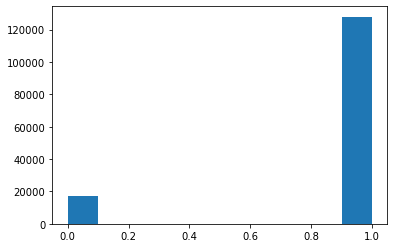

In [24]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice([0,1],n_new, p=(p_new,1-p_new))


print(np.mean(new_page_converted))
plt.hist(new_page_converted);

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

0.8803640018172557


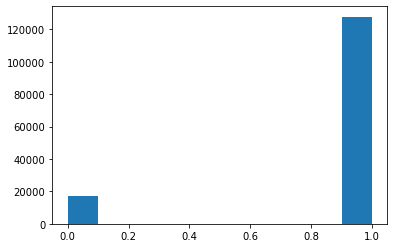

In [25]:
# Simulate a Sample for the control Group

    
old_page_converted = np.random.choice([0,1],n_old, p=(p_old,1-p_old))

print(old_page_converted.mean())
plt.hist(old_page_converted);

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [26]:
p_diff=(new_page_converted.mean())-(old_page_converted.mean())
p_diff

-9.423373522421397e-05

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

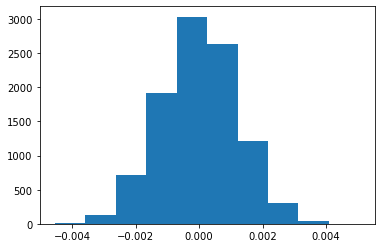

In [34]:
p_diffs = []

sample_controled = np.random.binomial(n=n_new,p=(p_new), size=10000)/n_new
sample_treated = np.random.binomial(n=n_old,p=(p_old) , size=10000)/n_old
diff=sample_controled-sample_treated
p_diffs.append(diff)
plt.hist(p_diffs);

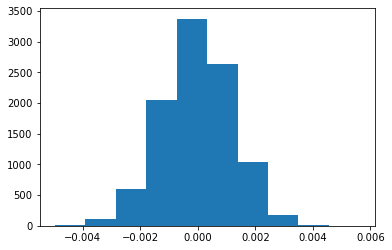

In [37]:
# Sampling distribution 
p_diffs = []

for _ in range(10000):
  
    sample_controled = np.random.choice([0,1],n_new,p=(p_new,1-p_new))
    sample_treated = np.random.choice([0,1],n_old,p=(p_old,1-p_old))
    diff=sample_controled.mean()-sample_treated.mean()
    p_diffs.append(diff)

plt.hist(p_diffs);


i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

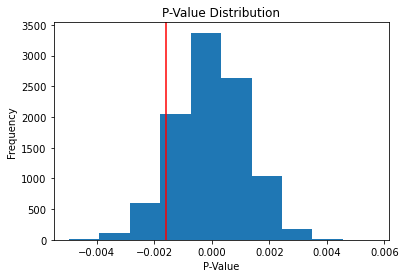

In [38]:
plt.hist(p_diffs)
plt.axvline(x= obs_diff, color = 'r');
plt.xlabel('P-Value')
plt.ylabel('Frequency')
plt.title('P-Value Distribution')

p_diffs=np.array(p_diffs)
under_null = np.random.normal(0, p_diffs.std(), 10000)


j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [39]:
P_value = (under_null > obs_diff).mean()
print(P_value)
print(obs_diff)
print(p_old)

0.9116
-0.0015782389853555567
0.11959708724499628


k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?


<center>
    The value Calculated is  <b><i>P_Value</i></b>
    <br>
    <b>Since P_Value  > Type I error (alpha) (0.05), So we Failed to Reject the Null Hypothesis.</b>
    </center>

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [40]:


convert_old = df2.query('group == "control" & converted==1')['user_id'].count()
convert_new = df2.query('group == "treatment" & converted==1')['user_id'].count()
n_old = n_old
n_new = n_new
convert_old,convert_new,n_old,n_new

(17489, 17264, 145274, 145310)

**m.** Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.  [Here](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) is a helpful link on using the built in.

The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 
>**Hint**: <br>
It's a two-tailed if you defined $H_1$ as $(p_{new} = p_{old})$. <br>
It's a left-tailed if you defined $H_1$ as $(p_{new} < p_{old})$. <br>
It's a right-tailed if you defined $H_1$ as $(p_{new} > p_{old})$. 

The built-in function above will return the z_score, p_value. 


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [41]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest([convert_new,convert_old], [n_new,n_old], alternative='larger')
print("Z_score = {} . \n P_Value = {} .  ".format(z_score, p_value))

Z_score = -1.3109241984234394 . 
 P_Value = 0.9050583127590245 .  


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

<center>
Since the $P{-value} $ is almost the same. Therfore, we failed to reject the null hypothesis.
<br> This result is the same as part J and K
    </center>

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

<center>
<b>Logistic regression since the outcome (response variable) is Catigorical variable (binary) (1 or 0).</b>
    </center>

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.
><i> here i will used the same way we dicussed in the connect session.</i>

In [42]:
df2.info()
model1 = smf.logit('converted  ~ group', df2).fit()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290584 non-null  int64 
 1   timestamp     290584 non-null  object
 2   group         290584 non-null  object
 3   landing_page  290584 non-null  object
 4   converted     290584 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 13.3+ MB
Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [43]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 23 Jan 2022   Pseudo R-squ.:               8.077e-06
Time:                        00:16:29   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -1.9888      0.008   -246.669      0.000      -2.005      -1.973
group[T.treatment]    -0.0150      0.011     -1.311      0.190      -0.037       0.007
======================================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

<center>
the P_$value$ Associated with ab_page(group) is 0.190.<br>
P_$value$>alpha (0.05) so there is no significant relationship betwwen the group and the conversion occurence.
  <br>  as it calculated consider other variable.

</center>
$H_0$ for the regression conclude there is no significant relationship betwwen the group and the conversion occurence.<br>
$Part II$ assumed the old_page (control) better than new_page (treatment) at a type I error rate of 5%.

    


f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Disadavantage to adding additional terms into regression model is <br>
in case the new terms are not independent it will requires to add another terms with higher than it to make the result better.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [73]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [74]:
model2 = smf.logit('converted  ~ landing_page+ country', df_new).fit()
model2.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sun, 23 Jan 2022   Pseudo R-squ.:               2.323e-05
Time:                        00:34:19   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -2.0450      0.027    -76.820      0.000      -2.097      -1.993
landing_page[T.old_page]     0.0149      0.011      1.307      0.191      -0.007       0.037
country[T.UK]                0.0506      0.028      1.784      0.074      -0.005       0.106
country[T.US]                0.0408      0.027      1.516      0.130      -0.012       0.093
============================================================================================
"""

In [75]:

params = np.exp(model2.params)
conf = np.exp(model2.conf_int())
conf['OR'] = params
pvalue=round(model2.pvalues,3)
conf['pvalue']=pvalue
conf.columns = ['CI 95%(2.5%)', 'CI 95%(97.5%)', 'Odds Ratio','pvalue']
print ((conf))

                          CI 95%(2.5%)  CI 95%(97.5%)  Odds Ratio  pvalue
Intercept                     0.122806       0.136314    0.129384   0.000
landing_page[T.old_page]      0.992561       1.038060    1.015056   0.191
country[T.UK]                 0.995003       1.112144    1.051944   0.074
country[T.US]                 0.988138       1.097953    1.041599   0.130


Result:<br>
**if old_page increase by 1 unit Conversion occurence will increase by 1.5%, holding all other varible constant.<br>
**if  pages for users located in UK increase by 1 unit Conversion occurence will increase by 5.2%, holding all other varible constant.<br>
**if  pages for users located in US increase by 1 unit Conversion occurence will increase by 4.2%, holding all other varible constant.<br>
** Therefore, the country where user lives is not significant on the converted rate considering the page the user using. 

<center>
<b> As all the P_values > 0.05 (alpha) so, there is no significant effect on converssion neigther for the country or the page whether it is new or old.</b>
    </center>

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [85]:
df_new2=df_new
df_new2['intercept'] = 1
df_new2= df_new.join(pd.get_dummies(df_new2['landing_page']))
df_new2['ab_page'] = pd.get_dummies(df_new2['group']) ['treatment']
df_new2[['CA','UK','US']] = pd.get_dummies(df_new['country'])
df_new2 = df_new2.drop(['US'], axis=1)
df_new2.head()

,country,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page,CA,UK
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,1


In [87]:

df_new2['new_page_UK'] = df_new2['ab_page'] * df_new2['UK']
df_new2['new_page_CA'] = df_new2['ab_page'] * df_new2['CA']

In [95]:
logit_mod = smf.logit('converted  ~ ab_page+UK+CA+new_page_UK+new_page_CA', df_new2).fit()

logit_mod.summary()


Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sun, 23 Jan 2022   Pseudo R-squ.:               3.482e-05
Time:                        02:04:28   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page        -0.0206      0.014     -1.505      0.132      -0.047       0.006
UK             -0.0057      0.019     -0.306      0.760      -0.043       0.031
CA             -0.0175      0.038     -0.465      0.642      -0.091       0.056
new_page_UK     0.0314      0.027      1.181      0.238      -0.021       0.084
new_page_CA    -0.0469      0.054     -0.872      0.383      -0.152       0.059
===============================================================================
"""

In [96]:
params = np.exp(logit_mod.params)
conf = np.exp(logit_mod.conf_int())
conf['OR'] = params
pvalue=round(logit_mod.pvalues,3)
conf['pvalue']=pvalue
conf.columns = ['CI 95%(2.5%)', 'CI 95%(97.5%)', 'Odds Ratio','pvalue']
print ((conf))

             CI 95%(2.5%)  CI 95%(97.5%)  Odds Ratio  pvalue
Intercept        0.134614       0.139791    0.137178   0.000
ab_page          0.953763       1.006233    0.979646   0.132
UK               0.958321       1.031573    0.994272   0.760
CA               0.912668       1.057944    0.982625   0.642
new_page_UK      0.979492       1.087104    1.031896   0.238
new_page_CA      0.858741       1.060265    0.954198   0.383


For every unit increase in ab_page , Convertion will be 2.9 % more likely to happen, holding all other varible constant.

Convertion is 1.03 time more likely to happen if the users are using the new page and lives in UK, holding all other varible constant.

Convertion is 0.95 time more likely to happen if the users are using the new page and lives in CA, holding all other varible constant.

Convertion is 99.4 % more likely to happen for the users in UK than US, holding all other varible constant.

Convertion is 98.3 % more likely to happen for the users in CA than US, holding all other varible constant.

<a id='conclusions'></a>
## Conclusions

based on all the above statistical results we conclude that implementing the new page will not lead to significant change on the Convertion rate for the users.

In [98]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0